Libraries

In [ ]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

       time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0          1970-03-25T00:00:00.440000       0.000000  -5.481780e-15
1          1970-03-25T00:00:00.590943       0.150943  -6.878653e-15
2          1970-03-25T00:00:00.741887       0.301887  -7.486137e-15
3          1970-03-25T00:00:00.892830       0.452830  -7.191481e-15
4          1970-03-25T00:00:01.043774       0.603774  -6.287278e-15
...                               ...            ...            ...
572406     1970-03-26T00:00:01.345660   86400.905660   8.188906e-16
572407     1970-03-26T00:00:01.496604   86401.056604  -6.852630e-17
572408     1970-03-26T00:00:01.647547   86401.207547  -8.490759e-16
572409     1970-03-26T00:00:01.798491   86401.358491  -1.930016e-15
572410     1970-03-26T00:00:01.949434   86401.509434  -3.466622e-15

[555645 rows x 3 columns]
                                 filename time_abs(%Y-%m-%dT%H:%M:%S.%f)  \
0  xa.s12.00.mhz.1970-03-25HR00_evid00003     1970-03-25T00:10:00.289057   
1  xa

/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_32482/2134781041.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
/var/folders/h0/l4h13f0s51z43l_g14315zsw0000gq/T/ipykernel_32482/2134781041.py:424: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)


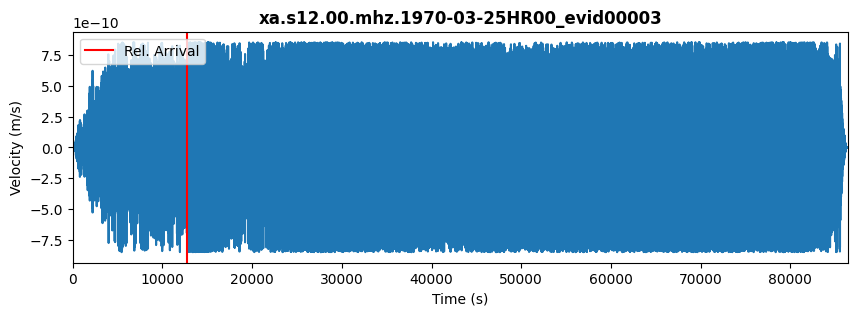

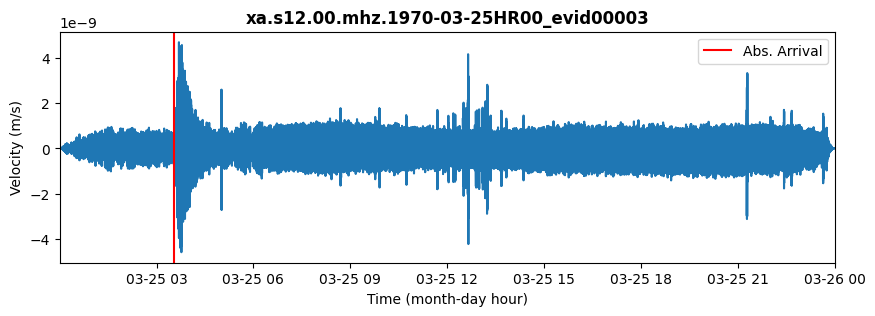

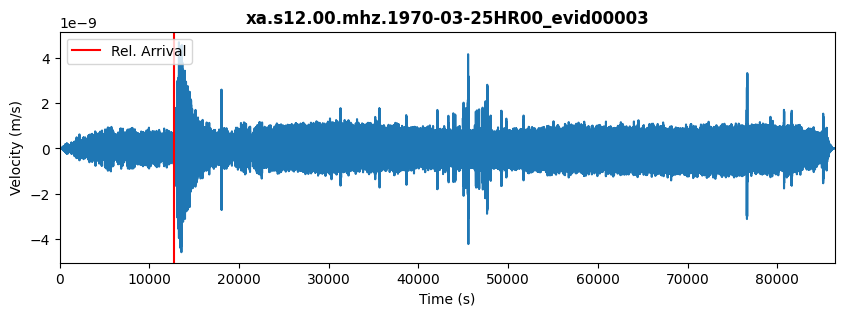

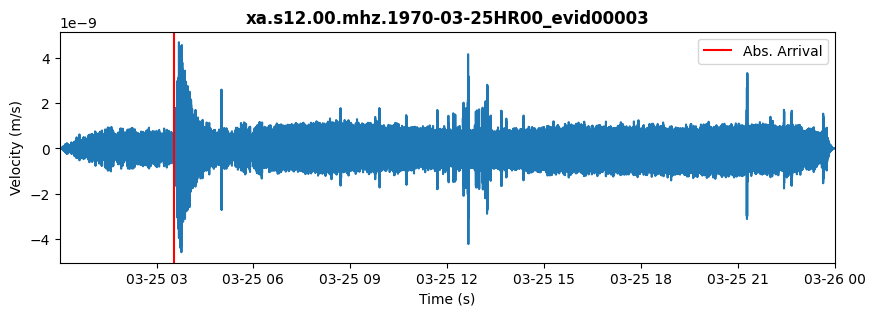

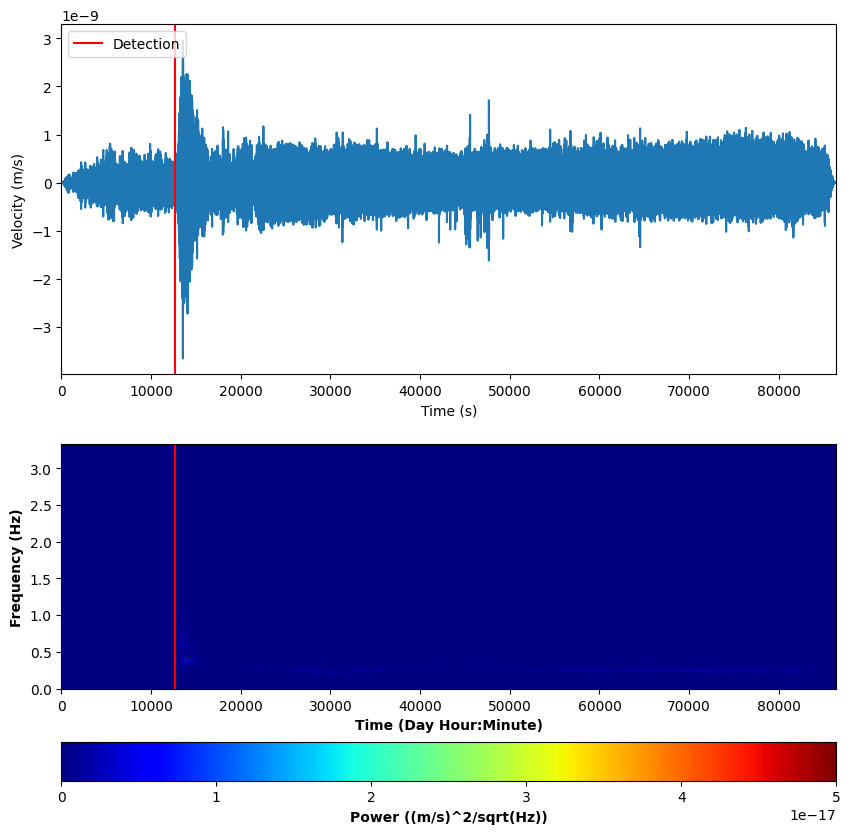

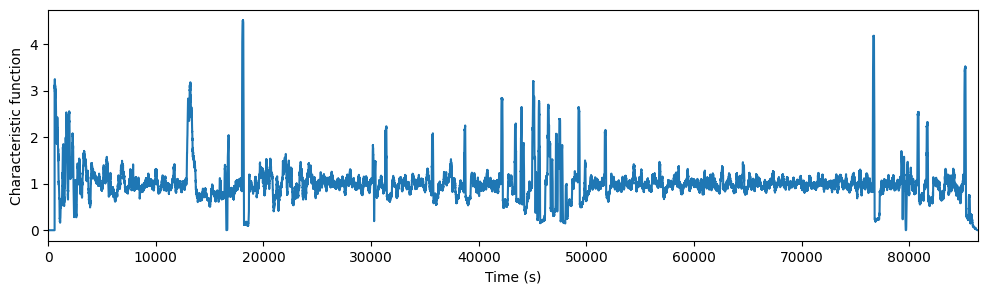

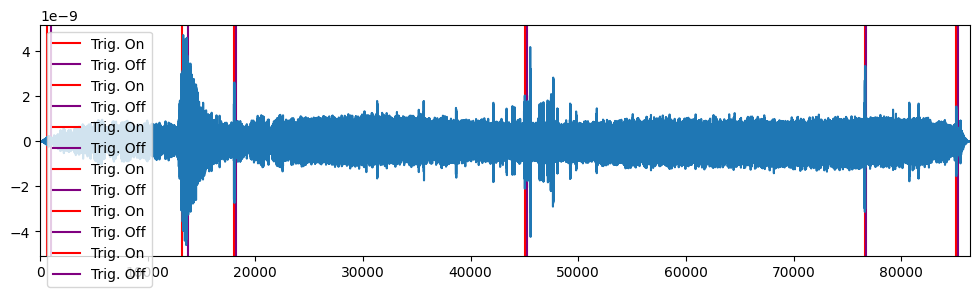

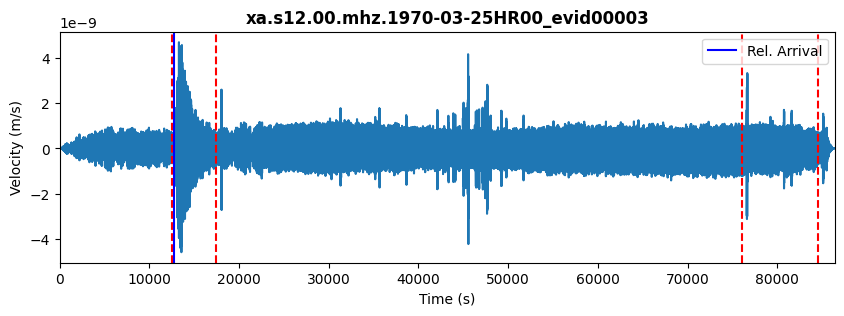

In [13]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat
row = cat.iloc[1]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time
# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel
# Let's also get the name of the file
test_filename = row.filename
test_filename
data_directory = './data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)
data_cat

#IQR

# Calcular el primer cuartil (Q1) y el tercer cuartil (Q3)
Q1 = data_cat['velocity(m/s)'].quantile(0.25)
Q3 = data_cat['velocity(m/s)'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar el DataFrame para eliminar outliers
clean_data_cat = data_cat[(data_cat['velocity(m/s)'] >= lower_bound) & (data_cat['velocity(m/s)'] <= upper_bound)]

# Mostrar el DataFrame limpio
print(clean_data_cat)

# Read in time steps and velocities
csv_times = np.array(clean_data_cat['time_rel(sec)'].tolist())
csv_data = np.array(clean_data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

# Read in time steps and velocities
csv_times_dt = []
for absval_str in data_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'].values:
    csv_times_dt.append(datetime.strptime(absval_str,'%Y-%m-%dT%H:%M:%S.%f'))

csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times_dt,csv_data)

# Make the plot pretty
ax.set_xlim((np.min(csv_times_dt),np.max(csv_times_dt)))
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (month-day hour)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
ax.legend(handles=[arrival_line])






data_directory = './data/lunar/training/data/S12_GradeA/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
st
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
arrival
# Initialize figure
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times,tr_data)

# Mark detection
ax.axvline(x = arrival, color='red',label='Rel. Arrival')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')
# Create a vector for the absolute time
tr_times_dt = []
for tr_val in tr_times:
    tr_times_dt.append(starttime + timedelta(seconds=tr_val))

# Plot the absolute result
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times_dt,tr_data)

# Mark detection
arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
ax.legend(handles=[arrival_line])

# Make the plot pretty
ax.set_xlim([min(tr_times_dt),max(tr_times_dt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')



# Set the minimum frequency
minfreq = 0.2
maxfreq = 0.7

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data
# To better see the patterns, we will create a spectrogram using the scipy function
# It requires the sampling rate, which we can get from the miniseed header as shown a few cells above
from scipy import signal
from matplotlib import cm
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)


# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')



from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 120
lta_len = 600

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term 
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')


# Play around with the on and off triggers, based on values in the characteristic function
thr_on = 3
thr_off = 1
on_off = np.array(trigger_onset(cft, thr_on, thr_off))


# The first column contains the indices where the trigger is turned "on". 
# The second column contains the indices where the trigger is turned "off".

# Plot on and off triggers
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')

# Plot seismogram
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()
# File name and start time of trace
fname = row.filename
starttime = tr.stats.starttime.datetime

# Iterate through detection times and compile them
detection_times = []
fnames = []
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    on_time = starttime + timedelta(seconds = tr_times[triggers[0]])
    on_time_str = datetime.strftime(on_time,'%Y-%m-%dT%H:%M:%S.%f')
    detection_times.append(on_time_str)
    fnames.append(fname)
    
# Compile dataframe of detections
detect_df = pd.DataFrame(data = {'filename':fnames, 'time_abs(%Y-%m-%dT%H:%M:%S.%f)':detection_times, 'time_rel(sec)':tr_times[triggers[0]]})
print(detect_df)


import pandas as pd
import numpy as np

# Definir una función para obtener el nombre de la columna de tiempo
def get_time_column_name(df):
    possible_names = ['time_abs', 'time_abs(%Y-%m-%dT%H:%M:%S.%f)']
    for name in possible_names:
        if name in df.columns:
            return name
    raise KeyError("No se encontró la columna de tiempo en el DataFrame.")

# Obtener el nombre de la columna de tiempo en ambos DataFrames
time_col_clean_cat = get_time_column_name(clean_data_cat)
time_col_detect = get_time_column_name(detect_df)

# Convertir la columna de tiempo a formato datetime
clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
detect_df[time_col_detect] = pd.to_datetime(detect_df[time_col_detect])

# Función para calcular variaciones
def calculate_variations(clean_data_cat, detect_df, time_col_cat, time_col_detect):
    results = []
    for index, row in detect_df.iterrows():
        detection_time = row[time_col_detect]

        # Filtrar clean_data_cat para obtener datos en el rango de interés
        start_time_prev = detection_time - pd.Timedelta(minutes=5)
        end_time_prev = detection_time
        start_time_post = detection_time
        end_time_post = detection_time + pd.Timedelta(minutes=5)

        # Promedio y potencia para 2 minutos previos
        prev_data = clean_data_cat[(clean_data_cat[time_col_cat] >= start_time_prev) & 
                                   (clean_data_cat[time_col_cat] <= end_time_prev)]

        if not prev_data.empty:
            prev_mean = prev_data['velocity(m/s)'].mean()
            prev_power = (prev_data['velocity(m/s)'] ** 2).mean()  # Cálculo de potencia
        else:
            prev_mean = 0
            prev_power = 0

        # Promedio y potencia para 2 minutos posteriores
        post_data = clean_data_cat[(clean_data_cat[time_col_cat] >= start_time_post) & 
                                   (clean_data_cat[time_col_cat] <= end_time_post)]

        if not post_data.empty:
            post_mean = post_data['velocity(m/s)'].mean()
            post_power = (post_data['velocity(m/s)'] ** 2).mean()  # Cálculo de potencia
        else:
            post_mean = 0
            post_power = 0

        # Calcular la variación de los promedios y potencias
        mean_variation = post_mean - prev_mean
        power_variation = post_power - prev_power

        # Almacenar resultados
        results.append({
            'time_abs': detection_time,
            'mean_variation': mean_variation,
            'power_variation': power_variation
        })

    return pd.DataFrame(results)

# Calcular variaciones para clean_data_cat
clean_variation_df = calculate_variations(clean_data_cat, detect_df, time_col_clean_cat, time_col_detect)

# Ordenar por variación de promedios
clean_variation_df_sorted_mean = clean_variation_df.sort_values(by='mean_variation', ascending=False)

# Ordenar por variación de potencia
clean_variation_df_sorted_power = clean_variation_df.sort_values(by='power_variation', ascending=False)

# Mostrar los DataFrames ordenados
print("Ordenado por variación de promedios (descendente) - Clean Data Cat:")
print(clean_variation_df_sorted_mean)

print("\nOrdenado por variación de potencias (descendente) - Clean Data Cat:")
print(clean_variation_df_sorted_power)


import pandas as pd
import numpy as np

# Asegúrate de que data_cat y detect_df ya estén definidos

# Definir una función para obtener el nombre de la columna de tiempo
def get_time_column_name(df):
    possible_names = ['time_abs', 'time_abs(%Y-%m-%dT%H:%M:%S.%f)']
    for name in possible_names:
        if name in df.columns:
            return name
    raise KeyError("No se encontró la columna de tiempo en el DataFrame.")

# Obtener el nombre de la columna de tiempo en ambos DataFrames
time_col_cat = get_time_column_name(data_cat)
time_col_detect = get_time_column_name(detect_df)

# Convertir la columna de tiempo a formato datetime
data_cat[time_col_cat] = pd.to_datetime(data_cat[time_col_cat])
detect_df[time_col_detect] = pd.to_datetime(detect_df[time_col_detect])

# Inicializar una lista para almacenar resultados
results = []

# Calcular variaciones
for index, row in detect_df.iterrows():
    detection_time = row[time_col_detect]
    
    # Filtrar data_cat para obtener datos en el rango de interés
    start_time_prev = detection_time - pd.Timedelta(minutes=5)
    end_time_prev = detection_time
    start_time_post = detection_time
    end_time_post = detection_time + pd.Timedelta(minutes=5)

    # Promedio y potencia para 2 minutos previos
    prev_data = data_cat[(data_cat[time_col_cat] >= start_time_prev) & 
                         (data_cat[time_col_cat] <= end_time_prev)]
    
    if not prev_data.empty:
        prev_mean = prev_data['velocity(m/s)'].mean()
        prev_power = (prev_data['velocity(m/s)'] ** 2).mean()  # Cálculo de potencia
    else:
        prev_mean = 0
        prev_power = 0

    # Promedio y potencia para 2 minutos posteriores
    post_data = data_cat[(data_cat[time_col_cat] >= start_time_post) & 
                         (data_cat[time_col_cat] <= end_time_post)]
    
    if not post_data.empty:
        post_mean = post_data['velocity(m/s)'].mean()
        post_power = (post_data['velocity(m/s)'] ** 2).mean()  # Cálculo de potencia
    else:
        post_mean = 0
        post_power = 0
    
    # Calcular la variación de los promedios y potencias
    mean_variation = post_mean - prev_mean
    power_variation = post_power - (prev_power if prev_power != 0 else 1e-10)  # Para evitar división por cero

    # Almacenar resultados
    results.append({
        'time_abs': detection_time,
        'mean_variation': mean_variation,
        'power_variation': power_variation
    })

# Crear el DataFrame final
variation_df = pd.DataFrame(results)

# Ordenar por variación de promedios
variation_df_sorted_mean = variation_df.sort_values(by='mean_variation', ascending=False)

# Ordenar por variación de potencia
variation_df_sorted_power = variation_df.sort_values(by='power_variation', ascending=False)

# Mostrar los DataFrames ordenados
print("Ordenado por variación de promedios (descendente):")
print(variation_df_sorted_mean)

print("\nOrdenado por variación de potencias (descendente):")
print(variation_df_sorted_power)


import pandas as pd

def assign_scores(df_sorted_mean, df_sorted_power, clean_df_sorted_mean, clean_df_sorted_power):
    # Inicializar un DataFrame para almacenar los puntajes
    score_df = pd.DataFrame(columns=['id', 'time_abs', 'score'])
    
    def update_scores(df, score_df, column_name):
        for idx, row in df.iterrows():
            time_abs = row['time_abs']
            score = 0
            position = df.index.get_loc(idx)
            if position == 0 or position == len(df) - 1:
                score += 2
            elif position == 1 or position == len(df) - 2:
                score += 1
            
            # Si el id ya está en score_df, sumamos el puntaje
            if idx in score_df['id'].values:
                score_df.loc[score_df['id'] == idx, 'score'] += score
            else:
                score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)
        return score_df
    
    # Actualizar puntajes con cada DataFrame
    score_df = update_scores(df_sorted_mean, score_df, 'mean_variation')
    score_df = update_scores(df_sorted_power, score_df, 'power_variation')
    score_df = update_scores(clean_df_sorted_mean, score_df, 'mean_variation')
    score_df = update_scores(clean_df_sorted_power, score_df, 'power_variation')

    # Ordenar por puntaje total
    score_df = score_df.sort_values(by='score', ascending=False).reset_index(drop=True)
    return score_df

# Asignar puntajes a los DataFrames ordenados por variación de promedios y potencias
score_df_clean = assign_scores(variation_df_sorted_mean, variation_df_sorted_power, clean_variation_df_sorted_mean, clean_variation_df_sorted_power)

# Mostrar el DataFrame final con puntajes
print(score_df_clean)

import numpy as np
import matplotlib.pyplot as plt

# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Extract the times with a score of 3 or more in relative time (convert to seconds if needed)
high_score_times = score_df_clean[score_df_clean['score'] >= 3]['time_abs'].tolist()

# Convert the high score times to relative times (assuming 'time_abs' is in a suitable format)
# Example: if 'time_abs' is in datetime, convert to seconds relative to the start time
relative_high_score_times = [(pd.to_datetime(time) - pd.to_datetime(score_df_clean['time_abs'].min())).total_seconds() for time in high_score_times]

# Plot the trace!
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(csv_times, csv_data)

# Plot vertical lines for each relative time with a score >= 3
for time in relative_high_score_times:
    ax.axvline(x=time, c='red', linestyle='--')

# Make the plot pretty
ax.set_xlim([min(csv_times), max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Add legend for the arrival line (optional)
arrival_line = ax.axvline(x=arrival_time_rel, c='blue', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

# Show the plot
plt.show()


In [ ]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat
for i in range(len(cat)):
    row = cat.iloc[i]
    arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
    arrival_time
    # If we want the value of relative time, we don't need to use datetime
    arrival_time_rel = row['time_rel(sec)']
    arrival_time_rel
    # Let's also get the name of the file
    test_filename = row.filename
    test_filename
    data_directory = './data/lunar/training/data/S12_GradeA/'
    csv_file = f'{data_directory}{test_filename}.csv'
    data_cat = pd.read_csv(csv_file)
    data_cat

    #IQR

    # Calcular el primer cuartil (Q1) y el tercer cuartil (Q3)
    Q1 = data_cat['velocity(m/s)'].quantile(0.25)
    Q3 = data_cat['velocity(m/s)'].quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites para los outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar el DataFrame para eliminar outliers
    clean_data_cat = data_cat[(data_cat['velocity(m/s)'] >= lower_bound) & (data_cat['velocity(m/s)'] <= upper_bound)]

    # Mostrar el DataFrame limpio
    print(clean_data_cat)

    # Read in time steps and velocities
    csv_times = np.array(clean_data_cat['time_rel(sec)'].tolist())
    csv_data = np.array(clean_data_cat['velocity(m/s)'].tolist())

    # Plot the trace! 
    fig,ax = plt.subplots(1,1,figsize=(10,3))
    ax.plot(csv_times,csv_data)

    # Make the plot pretty
    ax.set_xlim([min(csv_times),max(csv_times)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{test_filename}', fontweight='bold')

    # Plot where the arrival time is
    arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
    ax.legend(handles=[arrival_line])

    # Read in time steps and velocities
    csv_times_dt = []
    for absval_str in data_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'].values:
        csv_times_dt.append(datetime.strptime(absval_str,'%Y-%m-%dT%H:%M:%S.%f'))

    csv_data = np.array(data_cat['velocity(m/s)'].tolist())

    # Plot the trace! 
    fig,ax = plt.subplots(1,1,figsize=(10,3))
    ax.plot(csv_times_dt,csv_data)

    # Make the plot pretty
    ax.set_xlim((np.min(csv_times_dt),np.max(csv_times_dt)))
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (month-day hour)')
    ax.set_title(f'{test_filename}', fontweight='bold')

    # Plot where the arrival time is
    arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
    ax.legend(handles=[arrival_line])






    data_directory = './data/lunar/training/data/S12_GradeA/'
    mseed_file = f'{data_directory}{test_filename}.mseed'
    st = read(mseed_file)
    st
    # This is how you get the data and the time, which is in seconds
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data

    # Start time of trace (another way to get the relative arrival time using datetime)
    starttime = tr.stats.starttime.datetime
    arrival = (arrival_time - starttime).total_seconds()
    arrival
    # Initialize figure
    fig,ax = plt.subplots(1,1,figsize=(10,3))

    # Plot trace
    ax.plot(tr_times,tr_data)

    # Mark detection
    ax.axvline(x = arrival, color='red',label='Rel. Arrival')
    ax.legend(loc='upper left')

    # Make the plot pretty
    ax.set_xlim([min(tr_times),max(tr_times)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{test_filename}', fontweight='bold')
    # Create a vector for the absolute time
    tr_times_dt = []
    for tr_val in tr_times:
        tr_times_dt.append(starttime + timedelta(seconds=tr_val))

    # Plot the absolute result
    fig,ax = plt.subplots(1,1,figsize=(10,3))

    # Plot trace
    ax.plot(tr_times_dt,tr_data)

    # Mark detection
    arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
    ax.legend(handles=[arrival_line])

    # Make the plot pretty
    ax.set_xlim([min(tr_times_dt),max(tr_times_dt)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{test_filename}', fontweight='bold')



    # Set the minimum frequency
    minfreq = 0.2
    maxfreq = 0.7

    # Going to create a separate trace for the filter data
    st_filt = st.copy()
    st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
    tr_filt = st_filt.traces[0].copy()
    tr_times_filt = tr_filt.times()
    tr_data_filt = tr_filt.data
    # To better see the patterns, we will create a spectrogram using the scipy function
    # It requires the sampling rate, which we can get from the miniseed header as shown a few cells above
    from scipy import signal
    from matplotlib import cm
    f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)


    # Plot the time series and spectrogram
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(2, 1, 1)
    # Plot trace
    ax.plot(tr_times_filt,tr_data_filt)

    # Mark detection
    ax.axvline(x = arrival, color='red',label='Detection')
    ax.legend(loc='upper left')

    # Make the plot pretty
    ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')

    ax2 = plt.subplot(2, 1, 2)
    vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
    ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
    ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
    ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
    ax2.axvline(x=arrival, c='red')
    cbar = plt.colorbar(vals, orientation='horizontal')
    cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')



    from obspy.signal.invsim import cosine_taper
    from obspy.signal.filter import highpass
    from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

    # Sampling frequency of our trace
    df = tr.stats.sampling_rate

    # How long should the short-term and long-term window be, in seconds?
    sta_len = 120
    lta_len = 600

    # Run Obspy's STA/LTA to obtain a characteristic function
    # This function basically calculates the ratio of amplitude between the short-term 
    # and long-term windows, moving consecutively in time across the data
    cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

    # Plot characteristic function
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    ax.plot(tr_times,cft)
    ax.set_xlim([min(tr_times),max(tr_times)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Characteristic function')


    # Play around with the on and off triggers, based on values in the characteristic function
    thr_on = 3
    thr_off = 1
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))


    # The first column contains the indices where the trigger is turned "on". 
    # The second column contains the indices where the trigger is turned "off".

    # Plot on and off triggers
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    for i in np.arange(0,len(on_off)):
        triggers = on_off[i]
        ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
        ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')

    # Plot seismogram
    ax.plot(tr_times,tr_data)
    ax.set_xlim([min(tr_times),max(tr_times)])
    ax.legend()
    # File name and start time of trace
    fname = row.filename
    starttime = tr.stats.starttime.datetime

    # Iterate through detection times and compile them
    detection_times = []
    fnames = []
    for i in np.arange(0,len(on_off)):
        triggers = on_off[i]
        on_time = starttime + timedelta(seconds = tr_times[triggers[0]])
        on_time_str = datetime.strftime(on_time,'%Y-%m-%dT%H:%M:%S.%f')
        detection_times.append(on_time_str)
        fnames.append(fname)
        
    # Compile dataframe of detections
    detect_df = pd.DataFrame(data = {'filename':fnames, 'time_abs(%Y-%m-%dT%H:%M:%S.%f)':detection_times, 'time_rel(sec)':tr_times[triggers[0]]})
    print(detect_df)


    import pandas as pd
    import numpy as np

    # Definir una función para obtener el nombre de la columna de tiempo
    def get_time_column_name(df):
        possible_names = ['time_abs', 'time_abs(%Y-%m-%dT%H:%M:%S.%f)']
        for name in possible_names:
            if name in df.columns:
                return name
        raise KeyError("No se encontró la columna de tiempo en el DataFrame.")

    # Obtener el nombre de la columna de tiempo en ambos DataFrames
    time_col_clean_cat = get_time_column_name(clean_data_cat)
    time_col_detect = get_time_column_name(detect_df)

    # Convertir la columna de tiempo a formato datetime
    clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
    detect_df[time_col_detect] = pd.to_datetime(detect_df[time_col_detect])

    # Función para calcular variaciones
    def calculate_variations(clean_data_cat, detect_df, time_col_cat, time_col_detect):
        results = []
        for index, row in detect_df.iterrows():
            detection_time = row[time_col_detect]

            # Filtrar clean_data_cat para obtener datos en el rango de interés
            start_time_prev = detection_time - pd.Timedelta(minutes=5)
            end_time_prev = detection_time
            start_time_post = detection_time
            end_time_post = detection_time + pd.Timedelta(minutes=5)

            # Promedio y potencia para 2 minutos previos
            prev_data = clean_data_cat[(clean_data_cat[time_col_cat] >= start_time_prev) & 
                                    (clean_data_cat[time_col_cat] <= end_time_prev)]

            if not prev_data.empty:
                prev_mean = prev_data['velocity(m/s)'].mean()
                prev_power = (prev_data['velocity(m/s)'] ** 2).mean()  # Cálculo de potencia
            else:
                prev_mean = 0
                prev_power = 0

            # Promedio y potencia para 2 minutos posteriores
            post_data = clean_data_cat[(clean_data_cat[time_col_cat] >= start_time_post) & 
                                    (clean_data_cat[time_col_cat] <= end_time_post)]

            if not post_data.empty:
                post_mean = post_data['velocity(m/s)'].mean()
                post_power = (post_data['velocity(m/s)'] ** 2).mean()  # Cálculo de potencia
            else:
                post_mean = 0
                post_power = 0

            # Calcular la variación de los promedios y potencias
            mean_variation = post_mean - prev_mean
            power_variation = post_power - prev_power

            # Almacenar resultados
            results.append({
                'time_abs': detection_time,
                'mean_variation': mean_variation,
                'power_variation': power_variation
            })

        return pd.DataFrame(results)

    # Calcular variaciones para clean_data_cat
    clean_variation_df = calculate_variations(clean_data_cat, detect_df, time_col_clean_cat, time_col_detect)

    # Ordenar por variación de promedios
    clean_variation_df_sorted_mean = clean_variation_df.sort_values(by='mean_variation', ascending=False)

    # Ordenar por variación de potencia
    clean_variation_df_sorted_power = clean_variation_df.sort_values(by='power_variation', ascending=False)

    # Mostrar los DataFrames ordenados
    print("Ordenado por variación de promedios (descendente) - Clean Data Cat:")
    print(clean_variation_df_sorted_mean)

    print("\nOrdenado por variación de potencias (descendente) - Clean Data Cat:")
    print(clean_variation_df_sorted_power)


    import pandas as pd
    import numpy as np

    # Asegúrate de que data_cat y detect_df ya estén definidos

    # Definir una función para obtener el nombre de la columna de tiempo
    def get_time_column_name(df):
        possible_names = ['time_abs', 'time_abs(%Y-%m-%dT%H:%M:%S.%f)']
        for name in possible_names:
            if name in df.columns:
                return name
        raise KeyError("No se encontró la columna de tiempo en el DataFrame.")

    # Obtener el nombre de la columna de tiempo en ambos DataFrames
    time_col_cat = get_time_column_name(data_cat)
    time_col_detect = get_time_column_name(detect_df)

    # Convertir la columna de tiempo a formato datetime
    data_cat[time_col_cat] = pd.to_datetime(data_cat[time_col_cat])
    detect_df[time_col_detect] = pd.to_datetime(detect_df[time_col_detect])

    # Inicializar una lista para almacenar resultados
    results = []

    # Calcular variaciones
    for index, row in detect_df.iterrows():
        detection_time = row[time_col_detect]
        
        # Filtrar data_cat para obtener datos en el rango de interés
        start_time_prev = detection_time - pd.Timedelta(minutes=5)
        end_time_prev = detection_time
        start_time_post = detection_time
        end_time_post = detection_time + pd.Timedelta(minutes=5)

        # Promedio y potencia para 2 minutos previos
        prev_data = data_cat[(data_cat[time_col_cat] >= start_time_prev) & 
                            (data_cat[time_col_cat] <= end_time_prev)]
        
        if not prev_data.empty:
            prev_mean = prev_data['velocity(m/s)'].mean()
            prev_power = (prev_data['velocity(m/s)'] ** 2).mean()  # Cálculo de potencia
        else:
            prev_mean = 0
            prev_power = 0

        # Promedio y potencia para 2 minutos posteriores
        post_data = data_cat[(data_cat[time_col_cat] >= start_time_post) & 
                            (data_cat[time_col_cat] <= end_time_post)]
        
        if not post_data.empty:
            post_mean = post_data['velocity(m/s)'].mean()
            post_power = (post_data['velocity(m/s)'] ** 2).mean()  # Cálculo de potencia
        else:
            post_mean = 0
            post_power = 0
        
        # Calcular la variación de los promedios y potencias
        mean_variation = post_mean - prev_mean
        power_variation = post_power - (prev_power if prev_power != 0 else 1e-10)  # Para evitar división por cero

        # Almacenar resultados
        results.append({
            'time_abs': detection_time,
            'mean_variation': mean_variation,
            'power_variation': power_variation
        })

    # Crear el DataFrame final
    variation_df = pd.DataFrame(results)

    # Ordenar por variación de promedios
    variation_df_sorted_mean = variation_df.sort_values(by='mean_variation', ascending=False)

    # Ordenar por variación de potencia
    variation_df_sorted_power = variation_df.sort_values(by='power_variation', ascending=False)

    # Mostrar los DataFrames ordenados
    print("Ordenado por variación de promedios (descendente):")
    print(variation_df_sorted_mean)

    print("\nOrdenado por variación de potencias (descendente):")
    print(variation_df_sorted_power)


    import pandas as pd

    def assign_scores(df_sorted_mean, df_sorted_power, clean_df_sorted_mean, clean_df_sorted_power):
        # Inicializar un DataFrame para almacenar los puntajes
        score_df = pd.DataFrame(columns=['id', 'time_abs', 'score'])
        
        def update_scores(df, score_df, column_name):
            for idx, row in df.iterrows():
                time_abs = row['time_abs']
                score = 0
                position = df.index.get_loc(idx)
                if position == 0 or position == len(df) - 1:
                    score += 2
                elif position == 1 or position == len(df) - 2:
                    score += 1
                
                # Si el id ya está en score_df, sumamos el puntaje
                if idx in score_df['id'].values:
                    score_df.loc[score_df['id'] == idx, 'score'] += score
                else:
                    score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)
            return score_df
        
        # Actualizar puntajes con cada DataFrame
        score_df = update_scores(df_sorted_mean, score_df, 'mean_variation')
        score_df = update_scores(df_sorted_power, score_df, 'power_variation')
        score_df = update_scores(clean_df_sorted_mean, score_df, 'mean_variation')
        score_df = update_scores(clean_df_sorted_power, score_df, 'power_variation')

        # Ordenar por puntaje total
        score_df = score_df.sort_values(by='score', ascending=False).reset_index(drop=True)
        return score_df

    # Asignar puntajes a los DataFrames ordenados por variación de promedios y potencias
    score_df_clean = assign_scores(variation_df_sorted_mean, variation_df_sorted_power, clean_variation_df_sorted_mean, clean_variation_df_sorted_power)

    # Mostrar el DataFrame final con puntajes
    print(score_df_clean)

    import numpy as np
    import matplotlib.pyplot as plt

    # Read in time steps and velocities
    csv_times = np.array(data_cat['time_rel(sec)'].tolist())
    csv_data = np.array(data_cat['velocity(m/s)'].tolist())

    # Extract the times with a score of 3 or more in relative time (convert to seconds if needed)
    high_score_times = score_df_clean[score_df_clean['score'] >= 3]['time_abs'].tolist()

    # Convert the high score times to relative times (assuming 'time_abs' is in a suitable format)
    # Example: if 'time_abs' is in datetime, convert to seconds relative to the start time
    relative_high_score_times = [(pd.to_datetime(time) - pd.to_datetime(score_df_clean['time_abs'].min())).total_seconds() for time in high_score_times]

    # Plot the trace!
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(csv_times, csv_data)

    # Plot vertical lines for each relative time with a score >= 3
    for time in relative_high_score_times:
        ax.axvline(x=time, c='red', linestyle='--')

    # Make the plot pretty
    ax.set_xlim([min(csv_times), max(csv_times)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{test_filename}', fontweight='bold')

    # Add legend for the arrival line (optional)
    arrival_line = ax.axvline(x=arrival_time_rel, c='blue', label='Rel. Arrival')
    ax.legend(handles=[arrival_line])

    # Show the plot
    plt.show()


In [ ]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat
for i in range(len(cat)):
    row = cat.iloc[i]
    arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
    arrival_time
    # If we want the value of relative time, we don't need to use datetime
    arrival_time_rel = row['time_rel(sec)']
    arrival_time_rel
    # Let's also get the name of the file
    test_filename = row.filename
    test_filename
    data_directory = './data/lunar/training/data/S12_GradeA/'
    csv_file = f'{data_directory}{test_filename}.csv'
    data_cat = pd.read_csv(csv_file)
    data_cat

    #IQR

    # Calcular el primer cuartil (Q1) y el tercer cuartil (Q3)
    Q1 = data_cat['velocity(m/s)'].quantile(0.25)
    Q3 = data_cat['velocity(m/s)'].quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites para los outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar el DataFrame para eliminar outliers
    clean_data_cat = data_cat[(data_cat['velocity(m/s)'] >= lower_bound) & (data_cat['velocity(m/s)'] <= upper_bound)]

    # Mostrar el DataFrame limpio
    print(clean_data_cat)

    # Read in time steps and velocities
    csv_times = np.array(clean_data_cat['time_rel(sec)'].tolist())
    csv_data = np.array(clean_data_cat['velocity(m/s)'].tolist())

    data_directory = './data/lunar/training/data/S12_GradeA/'
    mseed_file = f'{data_directory}{test_filename}.mseed'
    st = read(mseed_file)
    st
    # This is how you get the data and the time, which is in seconds
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data

    # Start time of trace (another way to get the relative arrival time using datetime)
    starttime = tr.stats.starttime.datetime
    arrival = (arrival_time - starttime).total_seconds()
    arrival
    # Set the minimum frequency
    minfreq = 0.2
    maxfreq = 0.7

    # Going to create a separate trace for the filter data
    st_filt = st.copy()
    st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
    tr_filt = st_filt.traces[0].copy()
    tr_times_filt = tr_filt.times()
    tr_data_filt = tr_filt.data
    # To better see the patterns, we will create a spectrogram using the scipy function
    # It requires the sampling rate, which we can get from the miniseed header as shown a few cells above
    from scipy import signal
    from matplotlib import cm
    f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)


    # Plot the time series and spectrogram
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(2, 1, 1)
    # Plot trace
    ax.plot(tr_times_filt,tr_data_filt)

    # Mark detection
    ax.axvline(x = arrival, color='red',label='Detection')
    ax.legend(loc='upper left')

    # Make the plot pretty
    ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')

    ax2 = plt.subplot(2, 1, 2)
    vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
    ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
    ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
    ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
    ax2.axvline(x=arrival, c='red')
    cbar = plt.colorbar(vals, orientation='horizontal')
    cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

    # Sampling frequency of our trace
    df = tr.stats.sampling_rate

    # How long should the short-term and long-term window be, in seconds?
    sta_len = 120
    lta_len = 600

    # Run Obspy's STA/LTA to obtain a characteristic function
    # This function basically calculates the ratio of amplitude between the short-term 
    # and long-term windows, moving consecutively in time across the data
    cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

    # Plot characteristic function
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    ax.plot(tr_times,cft)
    ax.set_xlim([min(tr_times),max(tr_times)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Characteristic function')


    # Play around with the on and off triggers, based on values in the characteristic function
    thr_on = 3
    thr_off = 1
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))


    # The first column contains the indices where the trigger is turned "on". 
    # The second column contains the indices where the trigger is turned "off".

    # Plot on and off triggers
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    for i in np.arange(0,len(on_off)):
        triggers = on_off[i]
        ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
        ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')

    # Plot seismogram
    ax.plot(tr_times,tr_data)
    ax.set_xlim([min(tr_times),max(tr_times)])
    ax.legend()
    # File name and start time of trace
    fname = row.filename
    starttime = tr.stats.starttime.datetime

    # Iterate through detection times and compile them
    detection_times = []
    fnames = []
    for i in np.arange(0,len(on_off)):
        triggers = on_off[i]
        on_time = starttime + timedelta(seconds = tr_times[triggers[0]])
        on_time_str = datetime.strftime(on_time,'%Y-%m-%dT%H:%M:%S.%f')
        detection_times.append(on_time_str)
        fnames.append(fname)
        
    # Compile dataframe of detections
    detect_df = pd.DataFrame(data = {'filename':fnames, 'time_abs(%Y-%m-%dT%H:%M:%S.%f)':detection_times, 'time_rel(sec)':tr_times[triggers[0]]})
    print(detect_df)


    # Definir una función para obtener el nombre de la columna de tiempo
    def get_time_column_name(df):
        possible_names = ['time_abs', 'time_abs(%Y-%m-%dT%H:%M:%S.%f)']
        for name in possible_names:
            if name in df.columns:
                return name
        raise KeyError("No se encontró la columna de tiempo en el DataFrame.")

    # Obtener el nombre de la columna de tiempo en ambos DataFrames
    time_col_clean_cat = get_time_column_name(clean_data_cat)
    time_col_detect = get_time_column_name(detect_df)

    # Convertir la columna de tiempo a formato datetime
    clean_data_cat[time_col_clean_cat] = pd.to_datetime(clean_data_cat[time_col_clean_cat])
    detect_df[time_col_detect] = pd.to_datetime(detect_df[time_col_detect])

    # Función para calcular variaciones
    def calculate_variations(clean_data_cat, detect_df, time_col_cat, time_col_detect):
        results = []
        for index, row in detect_df.iterrows():
            detection_time = row[time_col_detect]

            # Filtrar clean_data_cat para obtener datos en el rango de interés
            start_time_prev = detection_time - pd.Timedelta(minutes=5)
            end_time_prev = detection_time
            start_time_post = detection_time
            end_time_post = detection_time + pd.Timedelta(minutes=5)

            # Promedio y potencia para 2 minutos previos
            prev_data = clean_data_cat[(clean_data_cat[time_col_cat] >= start_time_prev) & 
                                    (clean_data_cat[time_col_cat] <= end_time_prev)]

            if not prev_data.empty:
                prev_mean = prev_data['velocity(m/s)'].mean()
                prev_power = (prev_data['velocity(m/s)'] ** 2).mean()  # Cálculo de potencia
            else:
                prev_mean = 0
                prev_power = 0

            # Promedio y potencia para 2 minutos posteriores
            post_data = clean_data_cat[(clean_data_cat[time_col_cat] >= start_time_post) & 
                                    (clean_data_cat[time_col_cat] <= end_time_post)]

            if not post_data.empty:
                post_mean = post_data['velocity(m/s)'].mean()
                post_power = (post_data['velocity(m/s)'] ** 2).mean()  # Cálculo de potencia
            else:
                post_mean = 0
                post_power = 0

            # Calcular la variación de los promedios y potencias
            mean_variation = post_mean - prev_mean
            power_variation = post_power - prev_power

            # Almacenar resultados
            results.append({
                'time_abs': detection_time,
                'mean_variation': mean_variation,
                'power_variation': power_variation
            })

        return pd.DataFrame(results)

    # Calcular variaciones para clean_data_cat
    clean_variation_df = calculate_variations(clean_data_cat, detect_df, time_col_clean_cat, time_col_detect)

    # Ordenar por variación de promedios
    clean_variation_df_sorted_mean = clean_variation_df.sort_values(by='mean_variation', ascending=False)

    # Ordenar por variación de potencia
    clean_variation_df_sorted_power = clean_variation_df.sort_values(by='power_variation', ascending=False)

    # Mostrar los DataFrames ordenados
    print("Ordenado por variación de promedios (descendente) - Clean Data Cat:")
    print(clean_variation_df_sorted_mean)

    print("\nOrdenado por variación de potencias (descendente) - Clean Data Cat:")
    print(clean_variation_df_sorted_power)

    # Definir una función para obtener el nombre de la columna de tiempo
    def get_time_column_name(df):
        possible_names = ['time_abs', 'time_abs(%Y-%m-%dT%H:%M:%S.%f)']
        for name in possible_names:
            if name in df.columns:
                return name
        raise KeyError("No se encontró la columna de tiempo en el DataFrame.")

    # Obtener el nombre de la columna de tiempo en ambos DataFrames
    time_col_cat = get_time_column_name(data_cat)
    time_col_detect = get_time_column_name(detect_df)

    # Convertir la columna de tiempo a formato datetime
    data_cat[time_col_cat] = pd.to_datetime(data_cat[time_col_cat])
    detect_df[time_col_detect] = pd.to_datetime(detect_df[time_col_detect])

    # Inicializar una lista para almacenar resultados
    results = []

    # Calcular variaciones
    for index, row in detect_df.iterrows():
        detection_time = row[time_col_detect]
        
        # Filtrar data_cat para obtener datos en el rango de interés
        start_time_prev = detection_time - pd.Timedelta(minutes=5)
        end_time_prev = detection_time
        start_time_post = detection_time
        end_time_post = detection_time + pd.Timedelta(minutes=5)

        # Promedio y potencia para 2 minutos previos
        prev_data = data_cat[(data_cat[time_col_cat] >= start_time_prev) & 
                            (data_cat[time_col_cat] <= end_time_prev)]
        
        if not prev_data.empty:
            prev_mean = prev_data['velocity(m/s)'].mean()
            prev_power = (prev_data['velocity(m/s)'] ** 2).mean()  # Cálculo de potencia
        else:
            prev_mean = 0
            prev_power = 0

        # Promedio y potencia para 2 minutos posteriores
        post_data = data_cat[(data_cat[time_col_cat] >= start_time_post) & 
                            (data_cat[time_col_cat] <= end_time_post)]
        
        if not post_data.empty:
            post_mean = post_data['velocity(m/s)'].mean()
            post_power = (post_data['velocity(m/s)'] ** 2).mean()  # Cálculo de potencia
        else:
            post_mean = 0
            post_power = 0
        
        # Calcular la variación de los promedios y potencias
        mean_variation = post_mean - prev_mean
        power_variation = post_power - (prev_power if prev_power != 0 else 1e-10)  # Para evitar división por cero

        # Almacenar resultados
        results.append({
            'time_abs': detection_time,
            'mean_variation': mean_variation,
            'power_variation': power_variation
        })

    # Crear el DataFrame final
    variation_df = pd.DataFrame(results)

    # Ordenar por variación de promedios
    variation_df_sorted_mean = variation_df.sort_values(by='mean_variation', ascending=False)

    # Ordenar por variación de potencia
    variation_df_sorted_power = variation_df.sort_values(by='power_variation', ascending=False)

    # Mostrar los DataFrames ordenados
    print("Ordenado por variación de promedios (descendente):")
    print(variation_df_sorted_mean)

    print("\nOrdenado por variación de potencias (descendente):")
    print(variation_df_sorted_power)

    def assign_scores(df_sorted_mean, df_sorted_power, clean_df_sorted_mean, clean_df_sorted_power):
        # Inicializar un DataFrame para almacenar los puntajes
        score_df = pd.DataFrame(columns=['id', 'time_abs', 'score'])
        
        def update_scores(df, score_df, column_name):
            for idx, row in df.iterrows():
                time_abs = row['time_abs']
                score = 0
                position = df.index.get_loc(idx)
                if position == 0 or position == len(df) - 1:
                    score += 2
                elif position == 1 or position == len(df) - 2:
                    score += 1
                
                # Si el id ya está en score_df, sumamos el puntaje
                if idx in score_df['id'].values:
                    score_df.loc[score_df['id'] == idx, 'score'] += score
                else:
                    score_df = pd.concat([score_df, pd.DataFrame({'id': [idx], 'time_abs': [time_abs], 'score': [score]})], ignore_index=True)
            return score_df
        
        # Actualizar puntajes con cada DataFrame
        score_df = update_scores(df_sorted_mean, score_df, 'mean_variation')
        score_df = update_scores(df_sorted_power, score_df, 'power_variation')
        score_df = update_scores(clean_df_sorted_mean, score_df, 'mean_variation')
        score_df = update_scores(clean_df_sorted_power, score_df, 'power_variation')

        # Ordenar por puntaje total
        score_df = score_df.sort_values(by='score', ascending=False).reset_index(drop=True)
        return score_df

    # Asignar puntajes a los DataFrames ordenados por variación de promedios y potencias
    score_df_clean = assign_scores(variation_df_sorted_mean, variation_df_sorted_power, clean_variation_df_sorted_mean, clean_variation_df_sorted_power)

    # Mostrar el DataFrame final con puntajes
    arrival_time_rel = row['time_abs(%Y-%m-%dT%H:%M:%S.%f)']
    print(arrival_time_rel)
    print(score_df_clean)
    

    # Read in time steps and velocities
    csv_times = np.array(data_cat['time_rel(sec)'].tolist())
    csv_data = np.array(data_cat['velocity(m/s)'].tolist())

    # Extract the times with a score of 3 or more in relative time (convert to seconds if needed)
    high_score_times = score_df_clean[score_df_clean['score'] >= 3]['time_abs'].tolist()

    # Convert the high score times to relative times (assuming 'time_abs' is in a suitable format)
    # Example: if 'time_abs' is in datetime, convert to seconds relative to the start time
    relative_high_score_times = [(pd.to_datetime(time) - pd.to_datetime(score_df_clean['time_abs'].min())).total_seconds() for time in high_score_times]

    # Plot the trace!
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(csv_times, csv_data)

    # Plot vertical lines for each relative time with a score >= 3
    for time in relative_high_score_times:
        ax.axvline(x=time, c='red', linestyle='--')

    # Make the plot pretty
    ax.set_xlim([min(csv_times), max(csv_times)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{test_filename}', fontweight='bold')

    # Add legend for the arrival line (optional)
    arrival_line = ax.axvline(x=arrival_time_rel, c='blue', label='Rel. Arrival')
    ax.legend(handles=[arrival_line])

    # Show the plot
    plt.show()


In [ ]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
columna=1
# Llamar a la función y almacenar el resultado
clean_data_cat, original_data_cat, test_filename, arrival_time_rel = read_and_clean_data(cat, columna)
print(f"Nombre del archivo: {test_filename}")
print(f"Tiempo de llegada relativo: {arrival_time_rel}")
print(f"Datos originales:\n{original_data_cat.head()}")
print(f"Datos limpios:\n{clean_data_cat.head()}")
csv_times = np.array(original_data_cat['time_rel(sec)'].tolist())
csv_data = np.array(original_data_cat['velocity(m/s)'].tolist())
plot_velocity_trace(csv_data=csv_data, csv_times=csv_times, arrival_time_rel=arrival_time_rel, test_filename=test_filename)

data_directory = './data/lunar/training/data/S12_GradeA/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
st
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data
df = tr.stats.sampling_rate
# How long should the short-term and long-term window be, in seconds
sta_len = 120
lta_len = 600
thr_on = 3
thr_off = 1
detection_times = trigger_detection(tr_data=tr_data, tr_times=tr_times, df=df, sta_len=sta_len, lta_len=lta_len, thr_off=thr_off, thr_on=thr_on)
csv_times = np.array(original_data_cat['time_rel(sec)'].tolist())
csv_data = np.array(original_data_cat['velocity(m/s)'].tolist())
plot_velocity_trace_detection(csv_data=csv_data, csv_times=csv_times, detection_times=detection_times, arrival_time_rel=arrival_time_rel, test_filename=test_filename)
clean_variation_df_sorted_mean, clean_variation_df_sorted_power, variation_df_sorted_mean, variation_df_sorted_power = calculate_and_sort_variations(original_data_cat, clean_data_cat, detection_times)
scores_df = assign_scores(
    variation_df_sorted_mean,
    variation_df_sorted_power,
    clean_variation_df_sorted_mean,
    clean_variation_df_sorted_power
)
absolute_arrival= relative_to_absolute(relative_time=arrival_time_rel, test_filename=test_filename)
# Mostrar los resultados
print(f"Inicio de sismo desde catálogo: {absolute_arrival}")
print("DataFrame de Scores:")
print(scores_df)

